In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns # Visualization
import matplotlib.pyplot as plt # Visualization
from colorama import Fore

from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

import warnings # Supress warnings 
warnings.filterwarnings('ignore')

np.random.seed(7)

In [21]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here are several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        # print(os.path.join(dirname, filename))
        pass

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# <p style="background-color:skyblue; font-family:newtimeroman; font-size:180%; text-align:center">TimeSeries 📈 ARIMA, Prophet, ADF, PACF... 📚 Beginner to Pro</p>

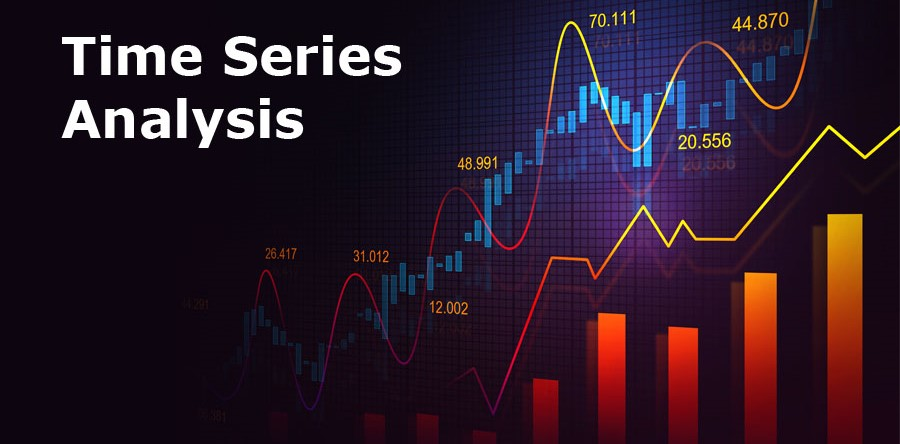

En este proyecto, quiero profundizar en el análisis TimeSeries para mostrar cómo revisar los datos, cómo previsualizarlos y cómo hacer ingeniería.

También quiero explorar algunos de los temas típicos de TimeSeries, tales como:
* ACF/PACF
* ARIMA
* Auto-ARIMA
* Prophet
* Dickey-Fuller Aumentado (ADF)


## <p style="background-color:skyblue; font-family:newtimeroman; font-size:120%; text-align:center">Contenido</p>

* [1. Visualización de datos 📊](#1)
* [2. Preprocesamiento de datos ⚙️](#2)
    * [2.1 Manejar las pérdidas](#2.1)
    * [2.2 Suavizado de datos / Remuestreo](#2.2)
    * [2.3 Estacionariedad](#2.3)
        * [2.3.1 Dickey-Fuller aumentado (ADF)](#2.3.1)
        * [2.3.2 Transformación](#2.3.2)
        * [2.3.3 Diferenciación](#2.3.3)
* [3. Ingeniería de funciones 🔧](#3)
    * [3.1 Codificación de características cíclicas](#3.1)
    * [3.2 Descomposición de series temporales](#3.2)
    * [3.3 Lag](#3.3)
* [4. Análisis exploratorio de datos 📊](#4)
    * [4.1 Análisis de autocorrelación](#4.1)
* [5. Modelado](#5)
    * [5.1 Modelos de series temporales univariantes](#5.1)
        * [5.1.1 Profeta univariante](#5.1.1)
        * [5.1.2 ARIMA](#5.1.2)
        * [5.1.3 Auto-ARIMA](#5.1.3)
        * [5.1.4 LSTM](#5.1.4)
    * [5.2 Modelos de series temporales multivariantes](#5.2)
        * [5.1.1 Profeta multivariante](#5.2.1)
* [6. Conclusiones](#6)
* [7. Referencias](#7)

In [22]:
df = pd.read_csv("/workspaces/time-series-project-tutorial/data/ACEA/Aquifer_Petrignano.csv")
df.head()

,Date,Rainfall_Bastia_Umbra,Depth_to_Groundwater_P24,Depth_to_Groundwater_P25,Temperature_Bastia_Umbra,Temperature_Petrignano,Volume_C10_Petrignano,Hydrometry_Fiume_Chiascio_Petrignano
0,14/03/2006,NaN,-22.48,-22.18,NaN,NaN,NaN,NaN
1,15/03/2006,NaN,-22.38,-22.14,NaN,NaN,NaN,NaN
2,16/03/2006,NaN,-22.25,-22.04,NaN,NaN,NaN,NaN
3,17/03/2006,NaN,-22.38,-22.04,NaN,NaN,NaN,NaN
4,18/03/2006,NaN,-22.60,-22.04,NaN,NaN,NaN,NaN


In [23]:
# Remove old rows
df = df[df.Rainfall_Bastia_Umbra.notna()].reset_index(drop=True)
# Remove not useful columns
df = df.drop(['Depth_to_Groundwater_P24', 'Temperature_Petrignano'], axis=1)

In [24]:
# Simplify column names
df.columns = ['date', 'rainfall', 'depth_to_groundwater', 'temperature', 'drainage_volume', 'river_hydrometry']

targets = ['depth_to_groundwater']
features = [feature for feature in df.columns if feature not in targets]
df.head()

,date,rainfall,depth_to_groundwater,temperature,drainage_volume,river_hydrometry
0,01/01/2009,0.0,-31.14,5.2,-24530.688,2.4
1,02/01/2009,0.0,-31.11,2.3,-28785.888,2.5
2,03/01/2009,0.0,-31.07,4.4,-25766.208,2.4
3,04/01/2009,0.0,-31.05,0.8,-27919.296,2.4
4,05/01/2009,0.0,-31.01,-1.9,-29854.656,2.3


Dado que se trata de un problema TimeSeries, tenemos que analizar la columna 'date'

In [25]:
from datetime import datetime, date 

df['date'] = pd.to_datetime(df['date'], format = '%d/%m/%Y')
df.head().style.set_properties(subset=['date'], **{'background-color': 'dodgerblue'})

,date,rainfall,depth_to_groundwater,temperature,drainage_volume,river_hydrometry
0,2009-01-01 00:00:00,0.000000,-31.140000,5.200000,-24530.688000,2.400000
1,2009-01-02 00:00:00,0.000000,-31.110000,2.300000,-28785.888000,2.500000
2,2009-01-03 00:00:00,0.000000,-31.070000,4.400000,-25766.208000,2.400000
3,2009-01-04 00:00:00,0.000000,-31.050000,0.800000,-27919.296000,2.400000
4,2009-01-05 00:00:00,0.000000,-31.010000,-1.900000,-29854.656000,2.300000


<a id='1'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center">1. Data visualization 📊</p>

Características:
- **Lluvia** indica la cantidad de lluvia caída (mm)
- **Temperatura** indica la temperatura (°C)
- **Volumen** indica el volumen de agua tomada de la planta potabilizadora (m³)
- **Hidrometría** indica el nivel de las aguas subterráneas (m)

Objetivo:
- **Profundidad hasta las aguas subterráneas** indica el nivel de las aguas subterráneas (m desde el suelo)

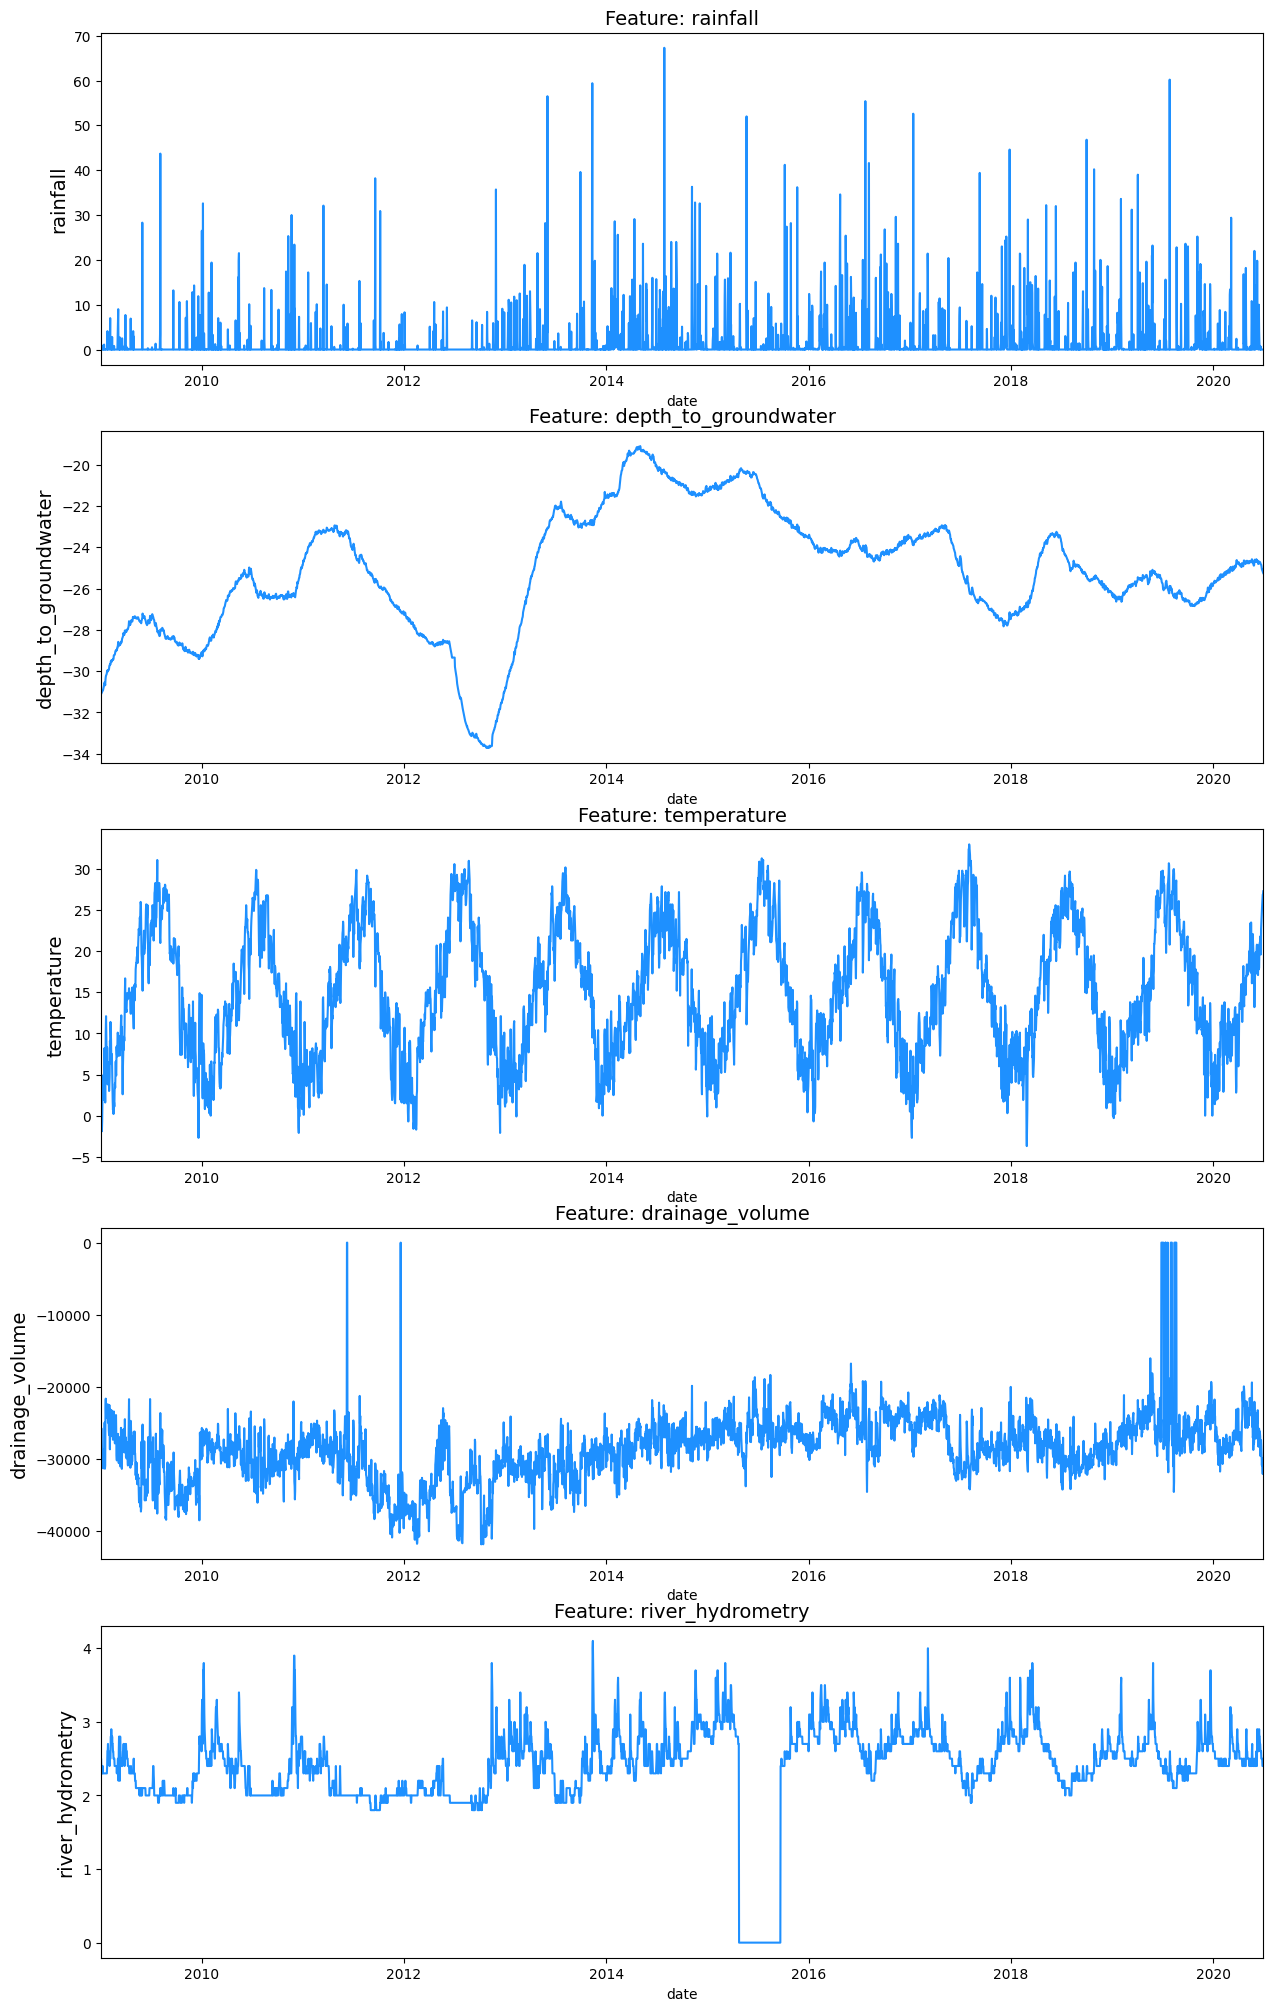

In [26]:
# To complete the data, as naive method, we will use .ffill()
f, ax = plt.subplots(nrows=5, ncols=1, figsize=(15, 25))

for i, column in enumerate(df.drop('date', axis=1).columns):
    sns.lineplot(x=df['date'], y=df[column].fillna(method='ffill'), ax=ax[i], color='dodgerblue')
    ax[i].set_title('Feature: {}'.format(column), fontsize=14)
    ax[i].set_ylabel(ylabel=column, fontsize=14)
                      
    ax[i].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])                

<a id='2'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center">2. Data Preprocessing ⚙️</p>

## Orden cronológico y marcas de tiempo equidistantes

Los datos deben estar en orden cronológico y las marcas de tiempo deben ser equidistantes en las series temporales. El orden cronológico puede conseguirse ordenando el marco de datos por las marcas de tiempo. Las marcas de tiempo equidistantes indican intervalos de tiempo constantes. Para comprobarlo, se puede tomar la diferencia entre cada marca de tiempo. Si no es el caso, puede decidirse por un intervalo de tiempo constante y volver a muestrear los datos.

Pero, antes de nada, ¡vamos a ver cómo comprobar si nuestro conjunto de datos está correctamente formateado!

In [27]:
df = df.sort_values(by='date')

# Check time intervals
df['delta'] = df['date'] - df['date'].shift(1)

df[['date', 'delta']].head()

,date,delta
0,2009-01-01,NaT
1,2009-01-02,1 days
2,2009-01-03,1 days
3,2009-01-04,1 days
4,2009-01-05,1 days


In [28]:
df['delta'].sum(), df['delta'].count()

(Timedelta('4198 days 00:00:00'), np.int64(4198))

Este ya es el caso de nuestros datos: El intervalo de tiempo es de un día y los datos ya están ordenados cronológicamente. Por lo tanto, no tenemos que hacer este paso adicional de preparación de datos.

<a id='2.1'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:120%; text-align:center">2.1 Manejar las pérdidas</p>

Como podemos ver, el conjunto de datos tiene algunos valores nulos.

Además, el trazado de las series temporales revela que parece haber **algunos valores cero que parecen ser nulos** para `volumen_drenaje`, y `hidrometría_fluvial`. Tendremos que limpiarlos sustituyéndolos por valores NaN y rellenándolos después.

In [29]:
df = df.drop('delta', axis=1)
df.isna().sum()

date                     0
rainfall                 0
depth_to_groundwater    27
temperature              0
drainage_volume          1
river_hydrometry         0
dtype: int64

(np.float64(14245.0), np.float64(18443.0))

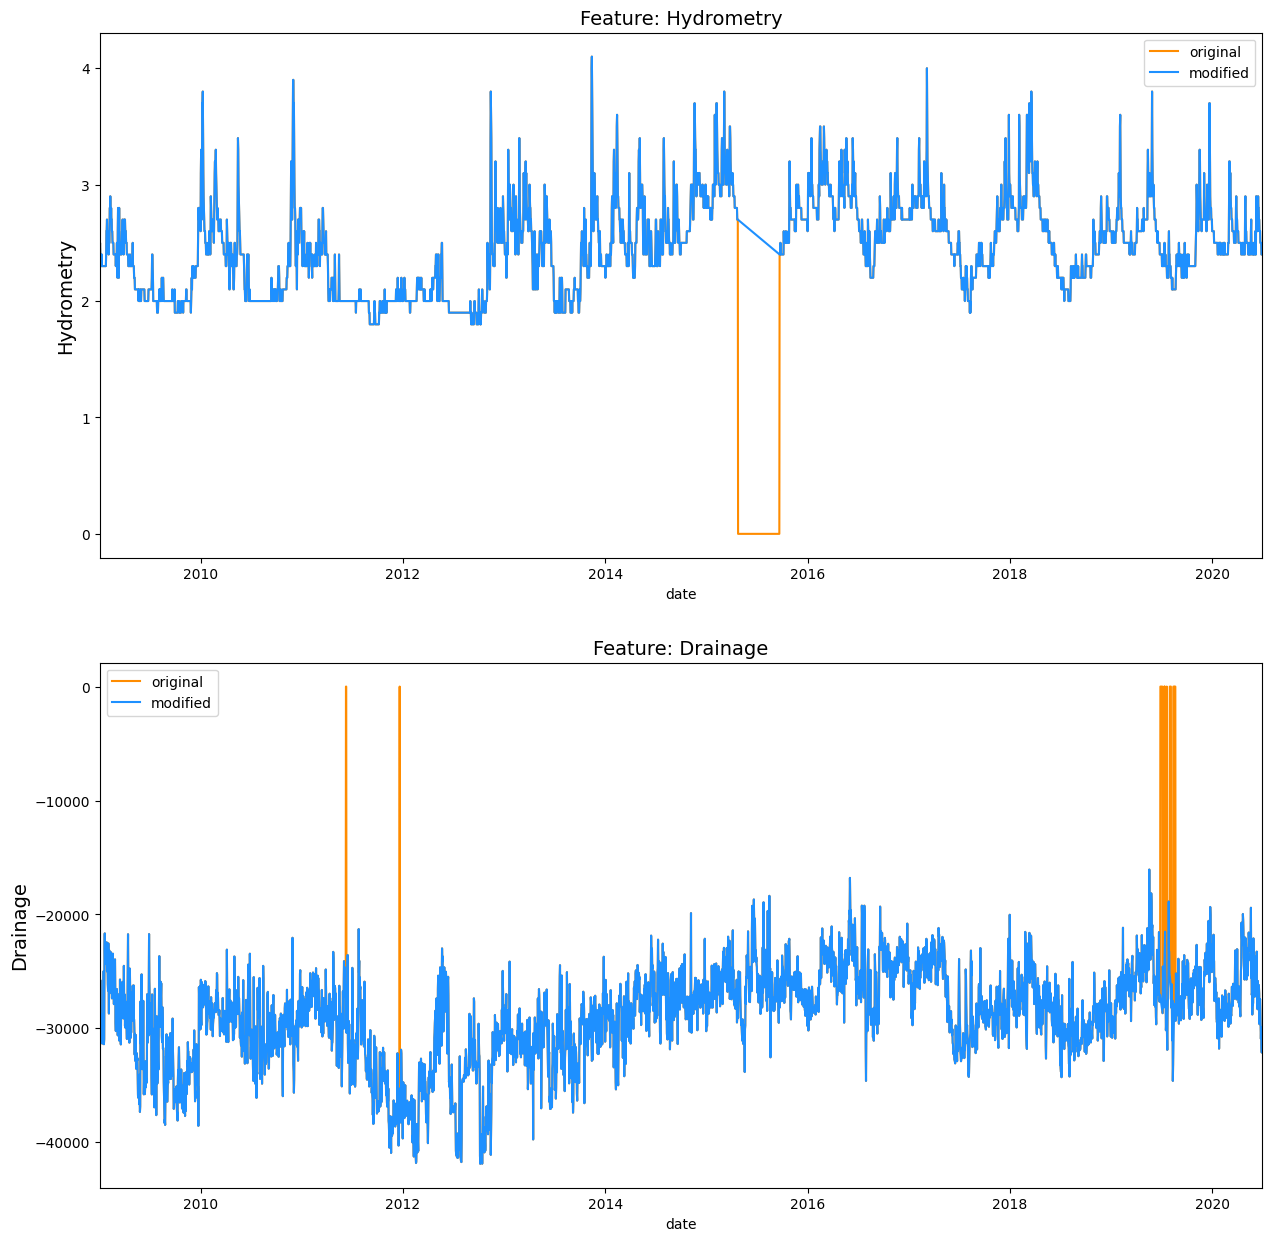

In [30]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))

old_hydrometry = df['river_hydrometry'].copy()
df['river_hydrometry'] = df['river_hydrometry'].replace(0, np.nan)

sns.lineplot(x=df['date'], y=old_hydrometry, ax=ax[0], color='darkorange', label='original')
sns.lineplot(x=df['date'], y=df['river_hydrometry'].fillna(np.inf), ax=ax[0], color='dodgerblue', label='modified')
ax[0].set_title('Feature: Hydrometry', fontsize=14)
ax[0].set_ylabel(ylabel='Hydrometry', fontsize=14)
ax[0].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

old_drainage = df['drainage_volume'].copy()
df['drainage_volume'] = df['drainage_volume'].replace(0, np.nan)

sns.lineplot(x=df['date'], y=old_drainage, ax=ax[1], color='darkorange', label='original')
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(np.inf), ax=ax[1], color='dodgerblue', label='modified')
ax[1].set_title('Feature: Drainage', fontsize=14)
ax[1].set_ylabel(ylabel='Drainage', fontsize=14)
ax[1].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

Así que ahora tenemos que corregir los valores que faltan. Echemos un vistazo a estos casos y veamos qué podemos hacer con ellos.

AttributeError: 'YTick' object has no attribute 'label'

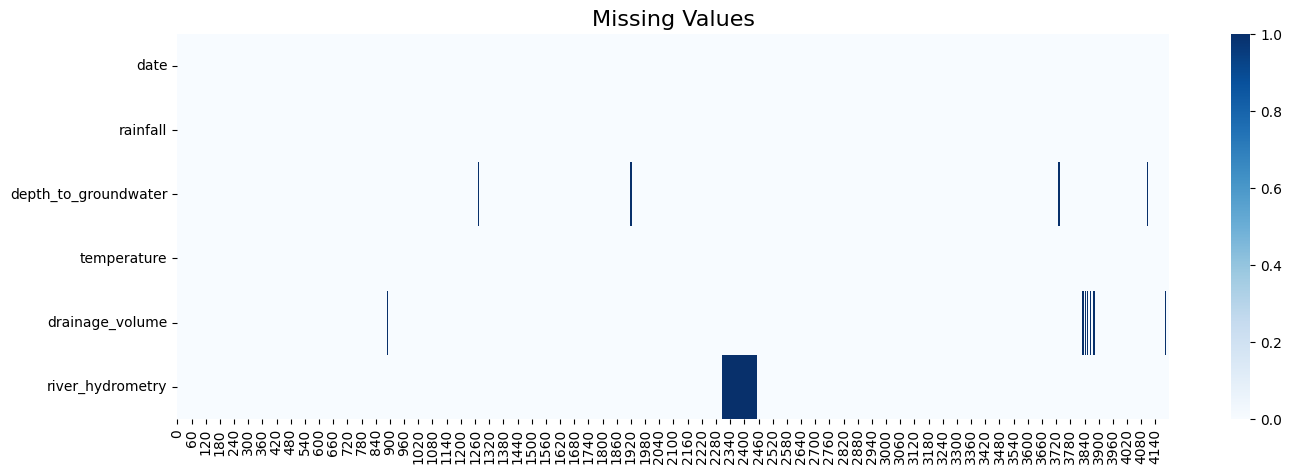

In [31]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,5))

sns.heatmap(df.T.isna(), cmap='Blues')
ax.set_title('Missing Values', fontsize=16)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
plt.show()

### Valores perdidos, cómo tratarlos

- **Opción 1: Rellenar NaN con un valor atípico o cero**.

En este ejemplo concreto, rellenar el valor que falta con un valor atípico como `np.inf` o 0 parece muy ingenuo. Sin embargo, utilizar valores como `-999`, a veces es una buena idea.

- **Opción 2: Rellenar NaN con valor medio**

Rellenar NaNs con el valor medio tampoco es suficiente e ingenuo, y no parece ser una buena opción.

- **Opción 3: Rellenar NaN con el último valor con .ffill()**

Rellenar NaNs con el último valor podría ser un poco mejor.

- **Opción 4: Rellenar NaN con valor interpolado linealmente con .interpolate()**

Rellenar los NaN con los valores interpolados es la mejor opción en este pequeño ejemplo, pero requiere conocer el valor vecino.

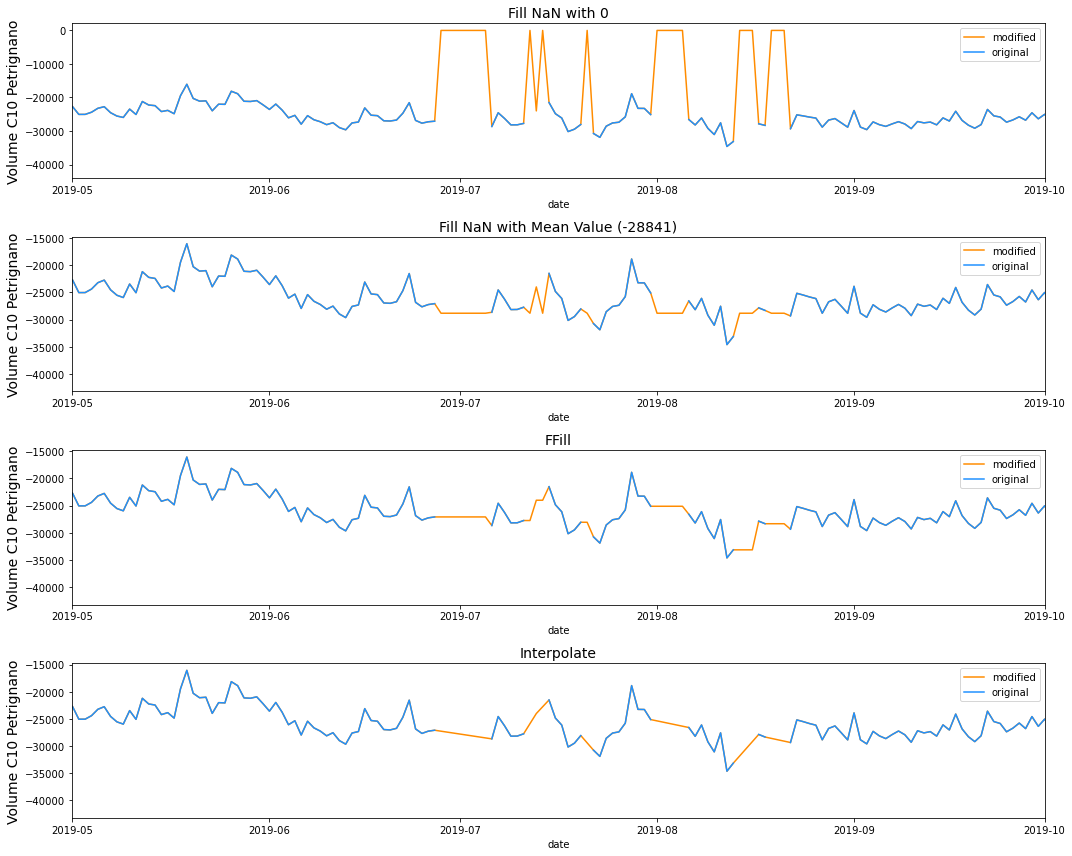

In [13]:
f, ax = plt.subplots(nrows=4, ncols=1, figsize=(15, 12))

sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(0), ax=ax[0], color='darkorange', label = 'modified')
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(np.inf), ax=ax[0], color='dodgerblue', label = 'original')
ax[0].set_title('Fill NaN with 0', fontsize=14)
ax[0].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)

mean_drainage = df['drainage_volume'].mean()
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(mean_drainage), ax=ax[1], color='darkorange', label = 'modified')
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(np.inf), ax=ax[1], color='dodgerblue', label = 'original')
ax[1].set_title(f'Fill NaN with Mean Value ({mean_drainage:.0f})', fontsize=14)
ax[1].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)

sns.lineplot(x=df['date'], y=df['drainage_volume'].ffill(), ax=ax[2], color='darkorange', label = 'modified')
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(np.inf), ax=ax[2], color='dodgerblue', label = 'original')
ax[2].set_title(f'FFill', fontsize=14)
ax[2].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)

sns.lineplot(x=df['date'], y=df['drainage_volume'].interpolate(), ax=ax[3], color='darkorange', label = 'modified')
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(np.inf), ax=ax[3], color='dodgerblue', label = 'original')
ax[3].set_title(f'Interpolate', fontsize=14)
ax[3].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)

for i in range(4):
    ax[i].set_xlim([date(2019, 5, 1), date(2019, 10, 1)])
    
plt.tight_layout()
plt.show()

Como podemos ver, la última opción en este caso, **parece ser la mejor opción!**

Entonces, vamos a interpolar los valores que faltan

In [14]:
df['drainage_volume'] = df['drainage_volume'].interpolate()
df['river_hydrometry'] = df['river_hydrometry'].interpolate()
df['depth_to_groundwater'] = df['depth_to_groundwater'].interpolate()

<a id='2.2'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:120%; text-align:center">2.2 Suavizado de datos / Remuestreo</p>

El remuestreo puede proporcionar información adicional sobre los datos. Existen dos tipos de remuestreo:

* **Muestreo creciente** aumenta la frecuencia de las muestras (por ejemplo, de días a horas).
* **Muestreo decreciente** se produce cuando se reduce la frecuencia de las muestras (por ejemplo, de días a semanas).

En este ejemplo, realizaremos un muestreo decreciente con la función `.resample()` (similar a groupby y aggregate as mean).

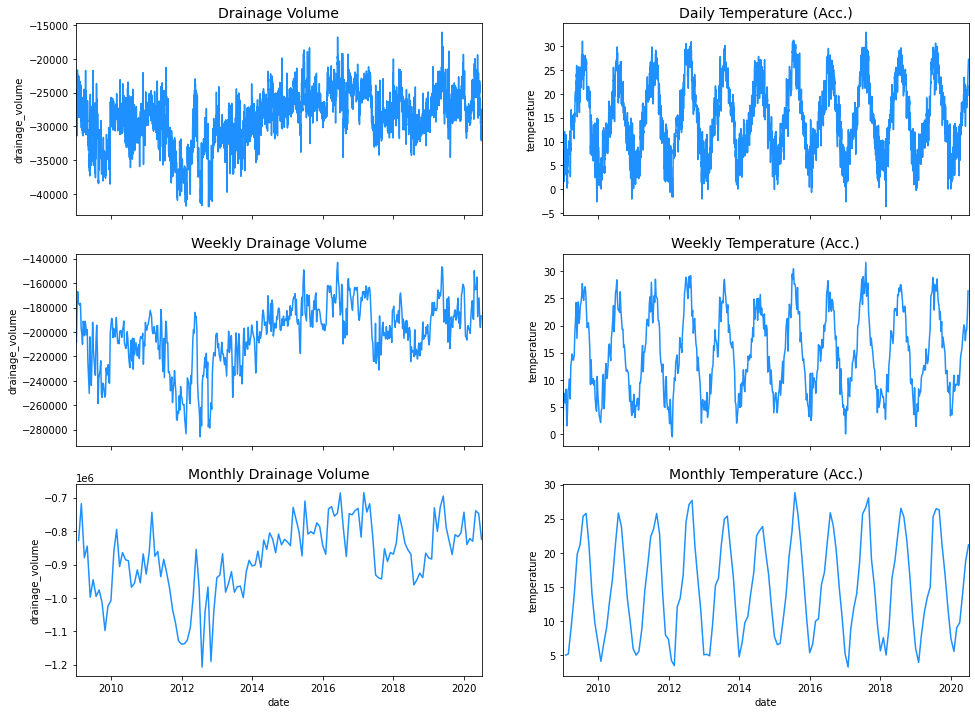

In [15]:
fig, ax = plt.subplots(ncols=2, nrows=3, sharex=True, figsize=(16,12))

sns.lineplot(df['date'], df['drainage_volume'], color='dodgerblue', ax=ax[0, 0])
ax[0, 0].set_title('Drainage Volume', fontsize=14)

resampled_df = df[['date','drainage_volume']].resample('7D', on='date').sum().reset_index(drop=False)
sns.lineplot(resampled_df['date'], resampled_df['drainage_volume'], color='dodgerblue', ax=ax[1, 0])
ax[1, 0].set_title('Weekly Drainage Volume', fontsize=14)

resampled_df = df[['date','drainage_volume']].resample('M', on='date').sum().reset_index(drop=False)
sns.lineplot(resampled_df['date'], resampled_df['drainage_volume'], color='dodgerblue', ax=ax[2, 0])
ax[2, 0].set_title('Monthly Drainage Volume', fontsize=14)

for i in range(3):
    ax[i, 0].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

sns.lineplot(df['date'], df['temperature'], color='dodgerblue', ax=ax[0, 1])
ax[0, 1].set_title('Daily Temperature (Acc.)', fontsize=14)

resampled_df = df[['date','temperature']].resample('7D', on='date').mean().reset_index(drop=False)
sns.lineplot(resampled_df['date'], resampled_df['temperature'], color='dodgerblue', ax=ax[1, 1])
ax[1, 1].set_title('Weekly Temperature (Acc.)', fontsize=14)

resampled_df = df[['date','temperature']].resample('M', on='date').mean().reset_index(drop=False)
sns.lineplot(resampled_df['date'], resampled_df['temperature'], color='dodgerblue', ax=ax[2, 1])
ax[2, 1].set_title('Monthly Temperature (Acc.)', fontsize=14)

for i in range(3):
    ax[i, 1].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
plt.show()

In [16]:
# As we can see, downsample to weekly could smooth the data and help with analysis
downsample = df[['date',
                 'depth_to_groundwater', 
                 'temperature',
                 'drainage_volume', 
                 'river_hydrometry',
                 'rainfall'
                ]].resample('7D', on='date').mean().reset_index(drop=False)

df = downsample.copy()

<a id='2.3'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:120%; text-align:center">2.3 Estacionariedad</p>

Algunos modelos de series temporales, como ARIMA, suponen que los datos subyacentes son estacionarios. La estacionariedad describe el hecho de que la serie temporal tiene:

- Media constante, y la media no depende del tiempo.
- Varianza constante, y la varianza no depende del tiempo.
- Covarianza constante, y la covarianza no depende del tiempo.

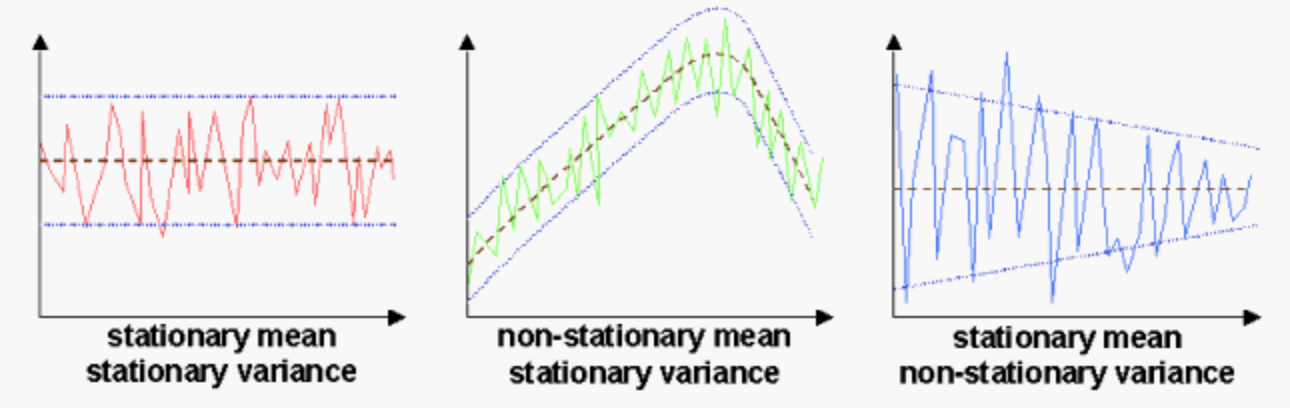

La comprobación de la estacionariedad puede realizarse mediante tres enfoques diferentes:

1. **Visualmente**: trace las series temporales y compruebe si hay tendencias o estacionalidad.
2. **Estadística básica**: dividir las series temporales y comparar la media y la varianza de cada partición.
3. **Pruebas estadísticas**: Prueba Dickey Fuller aumentada.

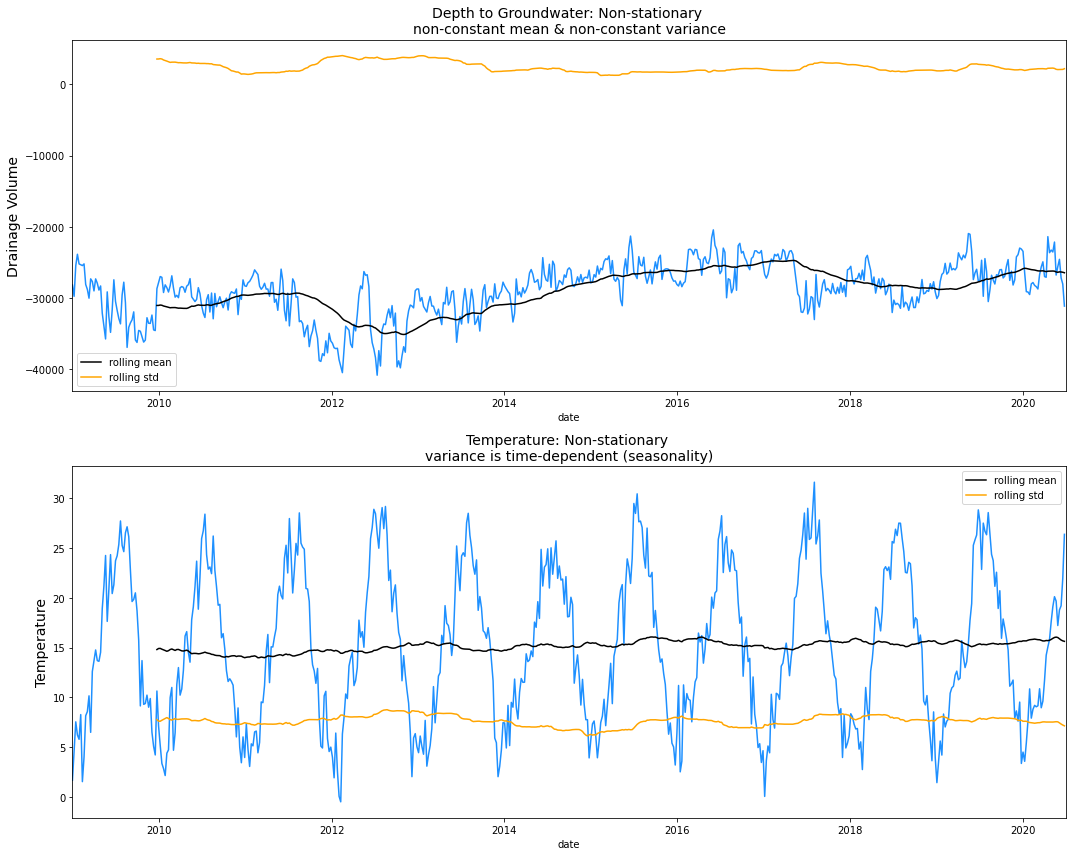

In [17]:
# A year has 52 weeks (52 weeks * 7 days per week) aprox.
rolling_window = 52
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 12))

sns.lineplot(x=df['date'], y=df['drainage_volume'], ax=ax[0], color='dodgerblue')
sns.lineplot(x=df['date'], y=df['drainage_volume'].rolling(rolling_window).mean(), ax=ax[0], color='black', label='rolling mean')
sns.lineplot(x=df['date'], y=df['drainage_volume'].rolling(rolling_window).std(), ax=ax[0], color='orange', label='rolling std')
ax[0].set_title('Depth to Groundwater: Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
ax[0].set_ylabel(ylabel='Drainage Volume', fontsize=14)
ax[0].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

sns.lineplot(x=df['date'], y=df['temperature'], ax=ax[1], color='dodgerblue')
sns.lineplot(x=df['date'], y=df['temperature'].rolling(rolling_window).mean(), ax=ax[1], color='black', label='rolling mean')
sns.lineplot(x=df['date'], y=df['temperature'].rolling(rolling_window).std(), ax=ax[1], color='orange', label='rolling std')
ax[1].set_title('Temperature: Non-stationary \nvariance is time-dependent (seasonality)', fontsize=14)
ax[1].set_ylabel(ylabel='Temperature', fontsize=14)
ax[1].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

plt.tight_layout()
plt.show()

En esta **comprobación visual**, podemos ver que las **características no tienen media y std** constantes, pero se acercan a ellas.

<a id='2.3.1'></a>
### Prueba de raíz unitaria

La raíz unitaria es una característica de una serie temporal que la hace no estacionaria, y la prueba ADF pertenece a la prueba de raíz unitaria. Técnicamente, se dice que existe una raíz unitaria en una serie temporal con un valor de `alpha=1` en la siguiente ecuación.

$Y_t = 	\alpha Y_{t-1} + 	\beta X_{e} + \epsilon $

Donde `Yt` es el valor de la serie temporal en el momento `t` y `Xe` es una variable exógena.

**La presencia de una raíz unitaria significa que la serie temporal no es estacionaria.**

## <p style="background-color:skyblue; font-family:newtimeroman; font-size:100%; text-align:center">2.3.1 Dickey-Fuller aumentado (ADF)</p>


**Dickey-Fuller aumentado (ADF)** es un tipo de prueba estadística denominada prueba de raíz unitaria. Las raíces unitarias son una causa de no estacionariedad.

**Hipótesis nula (H0)**: La serie temporal tiene una raíz unitaria. (La serie temporal no es estacionaria).

* Hipótesis alternativa (H1)**: La serie temporal no tiene raíz unitaria (La serie temporal es estacionaria).

**Si se rechaza la hipótesis nula, podemos concluir que la serie temporal es estacionaria.**

Hay dos formas de rechazar la hipótesis nula:

Por un lado, la hipótesis nula puede rechazarse si el `valor p` está por debajo de un nivel de significación establecido. El nivel de significación por defecto es del 5%.

* <font color='red'>**Valor p > nivel de significación (por defecto: 0,05)**</font>: Si no se rechaza la hipótesis nula (H0), los datos tienen una raíz unitaria y son <font color='red'>no estacionario</font>.
* <font color='green'>**valor p <= nivel de significación (por defecto: 0,05)**</font>: Rechace la hipótesis nula (H0), los datos no tienen una raíz unitaria y son <font color='green'>estacionario</font>.
    
Por otra parte, la hipótesis nula puede rechazarse si el estadístico de la prueba es inferior al valor crítico.

* <font color='red'>**Estadística ADF > valor crítico**</font>: Si no se rechaza la hipótesis nula (H0), los datos tienen una raíz unitaria y son <font color='red'>no estacionario</font>.
* <font color='green'>**Estadística ADF < valor crítico**</font>: Rechace la hipótesis nula (H0), los datos no tienen una raíz unitaria y son <font color='green'>estacionario</font>.

In [18]:
# https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['depth_to_groundwater'].values)
result

(-2.880201649316658,
 0.04769919092020916,
 7,
 592,
 {'1%': -3.441444394224128,
  '5%': -2.8664345376276454,
  '10%': -2.569376663737217},
 -734.3154255877625)

Ahora, vamos a comprobar para cada variable:
- El valor p es inferior a 0,05.
- Compruebe el rango del estadístico ADF en comparación con critical_values.

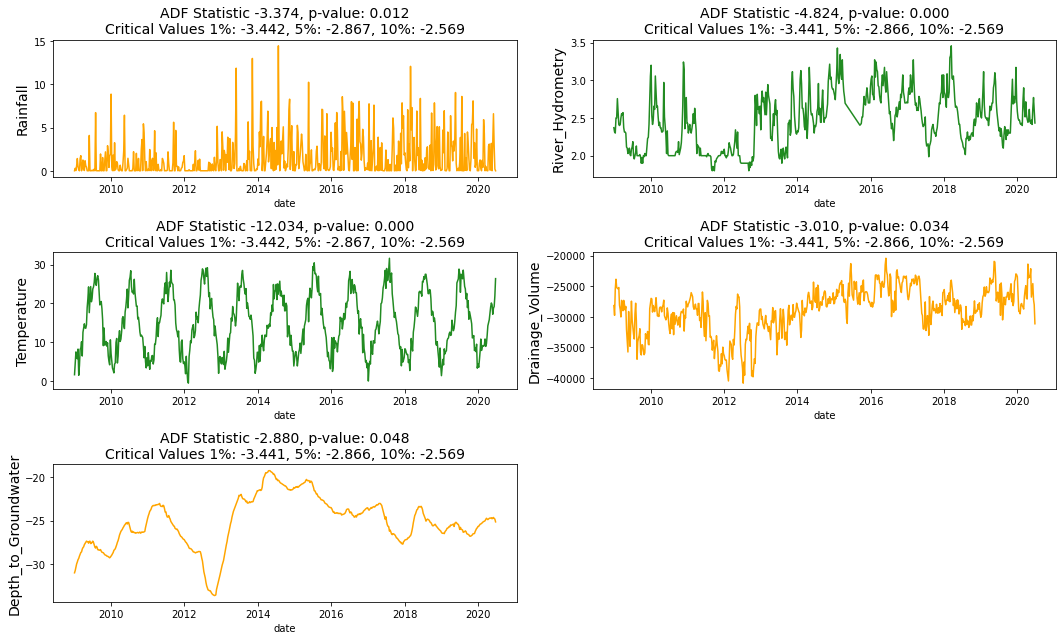

In [19]:
# Thanks to https://www.kaggle.com/iamleonie for this function!
f, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 9))

def visualize_adfuller_results(series, title, ax):
    result = adfuller(series)
    significance_level = 0.05
    adf_stat = result[0]
    p_val = result[1]
    crit_val_1 = result[4]['1%']
    crit_val_5 = result[4]['5%']
    crit_val_10 = result[4]['10%']

    if (p_val < significance_level) & ((adf_stat < crit_val_1)):
        linecolor = 'forestgreen' 
    elif (p_val < significance_level) & (adf_stat < crit_val_5):
        linecolor = 'orange'
    elif (p_val < significance_level) & (adf_stat < crit_val_10):
        linecolor = 'red'
    else:
        linecolor = 'purple'
    sns.lineplot(x=df['date'], y=series, ax=ax, color=linecolor)
    ax.set_title(f'ADF Statistic {adf_stat:0.3f}, p-value: {p_val:0.3f}\nCritical Values 1%: {crit_val_1:0.3f}, 5%: {crit_val_5:0.3f}, 10%: {crit_val_10:0.3f}', fontsize=14)
    ax.set_ylabel(ylabel=title, fontsize=14)

visualize_adfuller_results(df['rainfall'].values, 'Rainfall', ax[0, 0])
visualize_adfuller_results(df['temperature'].values, 'Temperature', ax[1, 0])
visualize_adfuller_results(df['river_hydrometry'].values, 'River_Hydrometry', ax[0, 1])
visualize_adfuller_results(df['drainage_volume'].values, 'Drainage_Volume', ax[1, 1])
visualize_adfuller_results(df['depth_to_groundwater'].values, 'Depth_to_Groundwater', ax[2, 0])

f.delaxes(ax[2, 1])
plt.tight_layout()
plt.show()

Si los datos no son estacionarios pero queremos utilizar un modelo como ARIMA (que requiere esta característica), hay que transformarlos.

Los dos métodos más comunes para transformar series en estacionarias son:

* **Transformación**: por ejemplo, logaritmo o raíz cuadrada para estabilizar la varianza no constante.
* **Diferenciación**: resta el valor actual del anterior.

<a id='2.3.2'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:100%; text-align:center">2.3.2 Transforming</p>

<AxesSubplot:xlabel='depth_to_groundwater_log', ylabel='Density'>

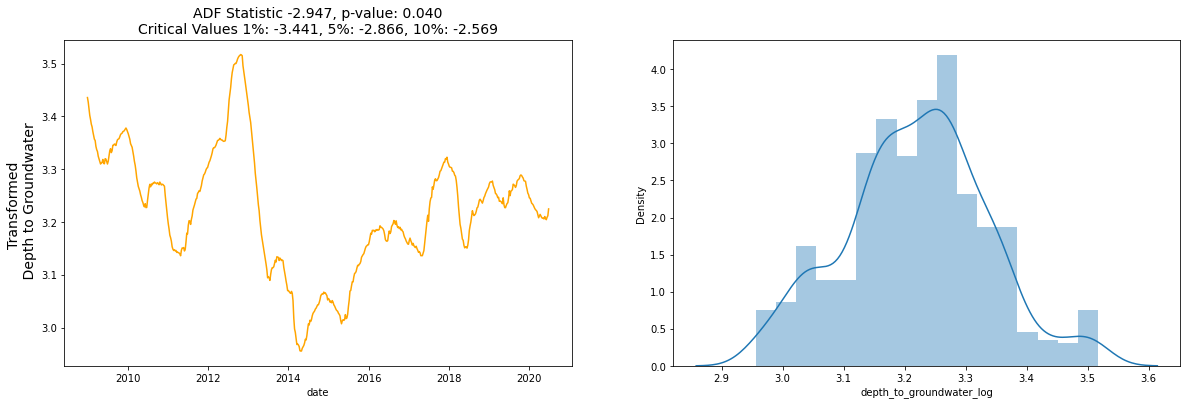

In [20]:
# Log Transform of absolute values
# (Log transoform of negative values will return NaN)
df['depth_to_groundwater_log'] = np.log(abs(df['depth_to_groundwater']))

f, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
visualize_adfuller_results(df['depth_to_groundwater_log'], 'Transformed \n Depth to Groundwater', ax[0])

sns.distplot(df['depth_to_groundwater_log'], ax=ax[1])

La diferenciación puede realizarse en diferentes órdenes:
* Diferenciación de primer orden: tendencias lineales con $z_i = y_i - y_{i-1}$
* Diferenciación de segundo orden: tendencias cuadráticas con $z_i = (y_i - y_{i-1}) - (y_{i-1} - y_{i-2})$
* Y así sucesivamente...

<a id='2.3.3'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:100%; text-align:center">2.3.3 Differencing</p>

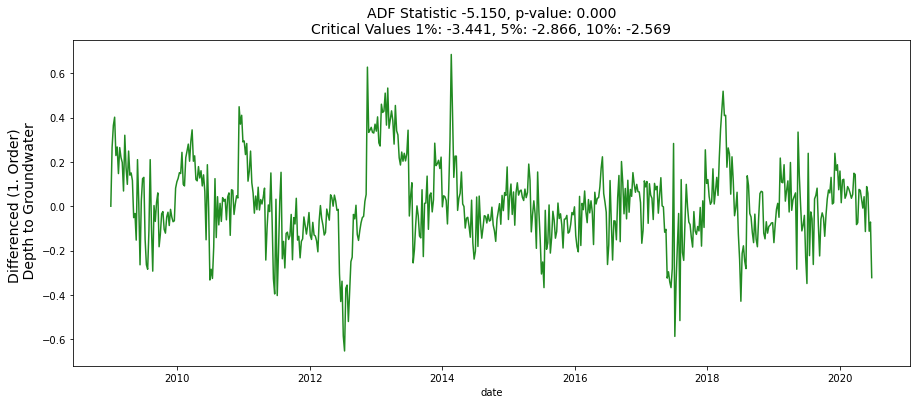

In [21]:
# First Order Differencing
ts_diff = np.diff(df['depth_to_groundwater'])
df['depth_to_groundwater_diff_1'] = np.append([0], ts_diff)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))
visualize_adfuller_results(df['depth_to_groundwater_diff_1'], 'Differenced (1. Order) \n Depth to Groundwater', ax)

<a id='3'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center">3. Feature engineering 🔧</p>

In [22]:
df['year'] = pd.DatetimeIndex(df['date']).year
df['month'] = pd.DatetimeIndex(df['date']).month
df['day'] = pd.DatetimeIndex(df['date']).day
df['day_of_year'] = pd.DatetimeIndex(df['date']).dayofyear
df['week_of_year'] = pd.DatetimeIndex(df['date']).weekofyear
df['quarter'] = pd.DatetimeIndex(df['date']).quarter
df['season'] = df['month'] % 12 // 3 + 1

df[['date', 'year', 'month', 'day', 'day_of_year', 'week_of_year', 'quarter', 'season']].head()

,date,year,month,day,day_of_year,week_of_year,quarter,season
0,2009-01-01,2009,1,1,1,1,1,1
1,2009-01-08,2009,1,8,8,2,1,1
2,2009-01-15,2009,1,15,15,3,1,1
3,2009-01-22,2009,1,22,22,4,1,1
4,2009-01-29,2009,1,29,29,5,1,1


<a id='3.1'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:120%; text-align:center">3.1 Codificación de características cíclicas</p>

Las nuevas características temporales son cíclicas. Por ejemplo, la característica mes tiene un ciclo entre 1 y 12 para cada año. Mientras que la diferencia entre cada mes aumenta en 1 durante el año, entre dos años la característica "mes" salta de 12 (diciembre) a 1 (enero). El resultado es una diferencia de -11, que puede confundir a muchos modelos.

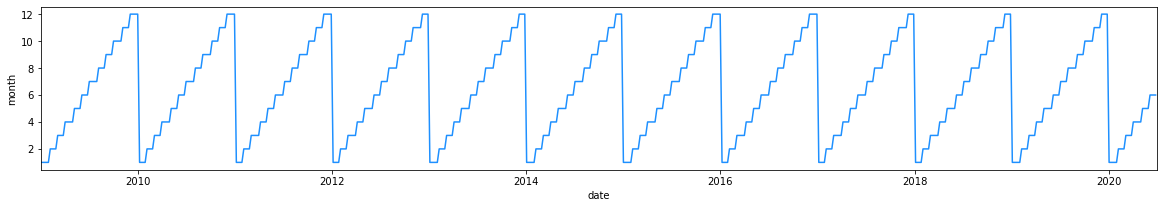

In [23]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 3))

sns.lineplot(x=df['date'], y=df['month'], color='dodgerblue')
ax.set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
plt.show()

Codifiquemos esta característica cíclica:

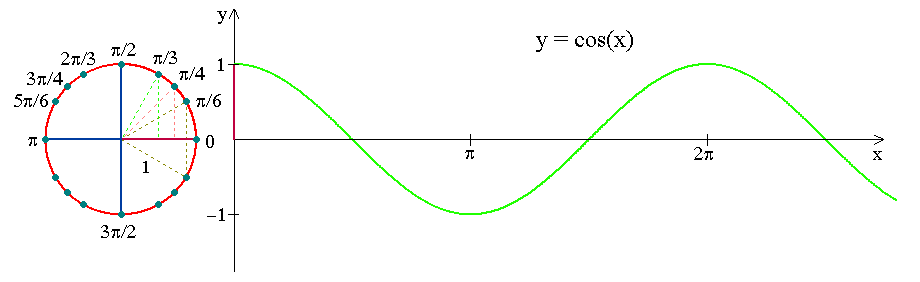

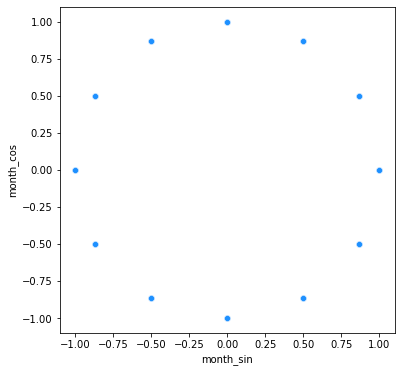

In [24]:
month_in_year = 12
df['month_sin'] = np.sin(2*np.pi*df['month']/month_in_year)
df['month_cos'] = np.cos(2*np.pi*df['month']/month_in_year)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

sns.scatterplot(x=df.month_sin, y=df.month_cos, color='dodgerblue')
plt.show()

<a id='3.2'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:120%; text-align:center">3.2 Descomposición de series temporales</p>

La descomposición de series temporales implica pensar en una serie como una combinación de componentes de nivel, tendencia, estacionalidad y ruido.

Estos componentes se definen del siguiente modo:

- **Nivel**: El valor medio de la serie.
- **Tendencia**: El valor creciente o decreciente en la serie.
- **Estacionalidad**: El ciclo que se repite a corto plazo en la serie.
- **Ruido**: La variación aleatoria de la serie.

La descomposición proporciona un modelo abstracto útil para pensar en las series temporales en general y para comprender mejor los problemas durante el análisis y la previsión de series temporales.

Todas las series tienen un nivel y ruido. Los componentes de tendencia y estacionalidad son opcionales.

Es útil pensar que los componentes se combinan de forma aditiva o multiplicativa:
- **Aditivo**: $y(t) = Level + Trend + Seasonality + Noise$
- **Multiplicativo**: $y(t) = Level * Trend * Seasonality * Noise$

En este caso, vamos a utilizar la función `seasonal_decompose()` de la biblioteca de [modelos estadísticos](https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html).

In [25]:
from statsmodels.tsa.seasonal import seasonal_decompose

core_columns =  [
    'rainfall', 'temperature', 'drainage_volume', 
    'river_hydrometry', 'depth_to_groundwater'
]

for column in core_columns:
    decomp = seasonal_decompose(df[column], period=52, model='additive', extrapolate_trend='freq')
    df[f"{column}_trend"] = decomp.trend
    df[f"{column}_seasonal"] = decomp.seasonal

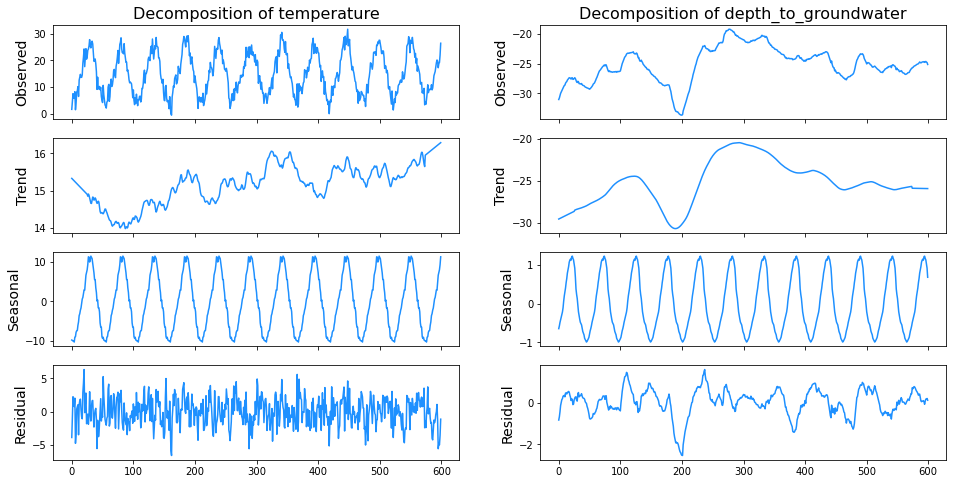

In [26]:
fig, ax = plt.subplots(ncols=2, nrows=4, sharex=True, figsize=(16,8))

for i, column in enumerate(['temperature', 'depth_to_groundwater']):
    
    res = seasonal_decompose(df[column], freq=52, model='additive', extrapolate_trend='freq')

    ax[0,i].set_title('Decomposition of {}'.format(column), fontsize=16)
    res.observed.plot(ax=ax[0,i], legend=False, color='dodgerblue')
    ax[0,i].set_ylabel('Observed', fontsize=14)

    res.trend.plot(ax=ax[1,i], legend=False, color='dodgerblue')
    ax[1,i].set_ylabel('Trend', fontsize=14)

    res.seasonal.plot(ax=ax[2,i], legend=False, color='dodgerblue')
    ax[2,i].set_ylabel('Seasonal', fontsize=14)
    
    res.resid.plot(ax=ax[3,i], legend=False, color='dodgerblue')
    ax[3,i].set_ylabel('Residual', fontsize=14)

plt.show()

<a id='3.3'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:120%; text-align:center">3.3 Lag</p>


Queremos calcular cada variable con un `shift()` (lag) para comparar la correlación con las demás variables.

Puede consultar la [documentación de la función shift](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.shift.html) para más información.

In [27]:
weeks_in_month = 4

for column in core_columns:
    df[f'{column}_seasonal_shift_b_2m'] = df[f'{column}_seasonal'].shift(-2 * weeks_in_month)
    df[f'{column}_seasonal_shift_b_1m'] = df[f'{column}_seasonal'].shift(-1 * weeks_in_month)
    df[f'{column}_seasonal_shift_1m'] = df[f'{column}_seasonal'].shift(1 * weeks_in_month)
    df[f'{column}_seasonal_shift_2m'] = df[f'{column}_seasonal'].shift(2 * weeks_in_month)
    df[f'{column}_seasonal_shift_3m'] = df[f'{column}_seasonal'].shift(3 * weeks_in_month)

<a id='4'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center">4. Análisis exploratorio de datos 📊</p>

Ahora vamos a trazar los datos e intentar extraer algunos conocimientos.

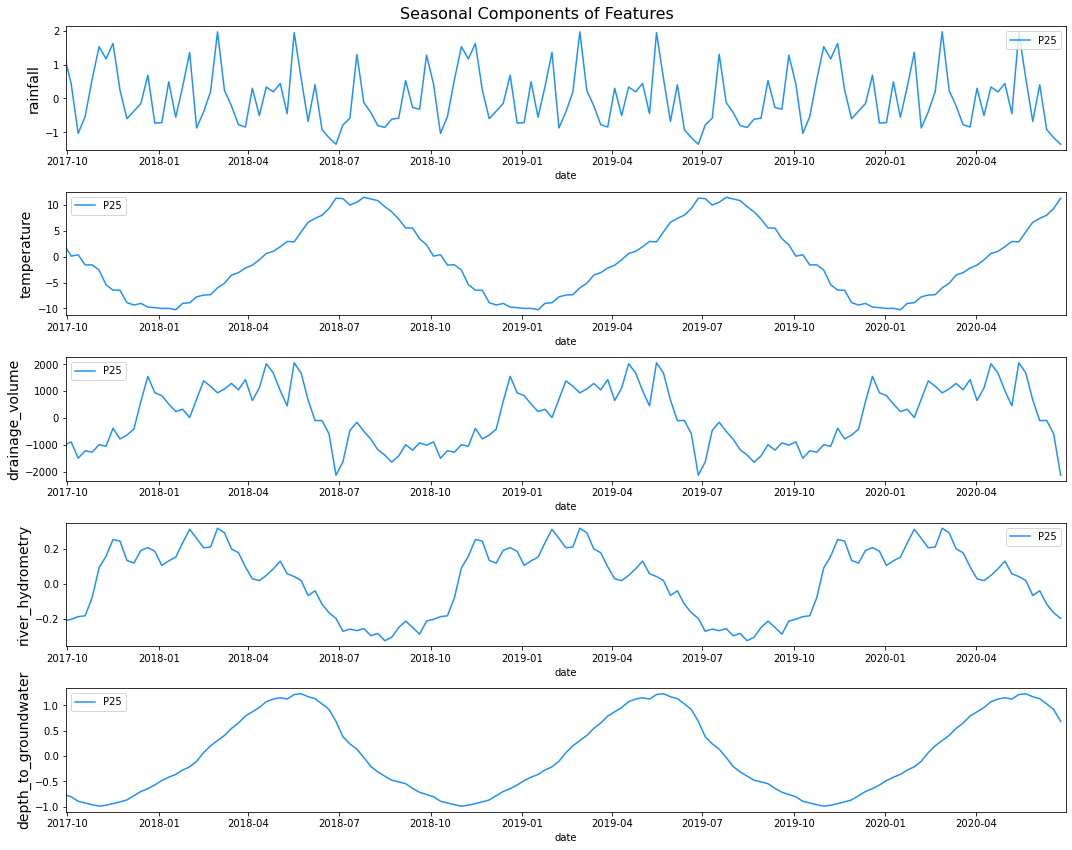

In [28]:
f, ax = plt.subplots(nrows=5, ncols=1, figsize=(15, 12))
f.suptitle('Seasonal Components of Features', fontsize=16)

for i, column in enumerate(core_columns):
    sns.lineplot(x=df['date'], y=df[column + '_seasonal'], ax=ax[i], color='dodgerblue', label='P25')
    ax[i].set_ylabel(ylabel=column, fontsize=14)
    ax[i].set_xlim([date(2017, 9, 30), date(2020, 6, 30)])
    
plt.tight_layout()
plt.show()

Como podemos ver:

- **depth_to_groundwater**: alcanza su máximo alrededor de mayo/junio y su mínimo alrededor de noviembre
- **temperature**: alcanza su máximo en agosto y su mínimo en enero
- **drainage_volume**: alcanza su mínimo en torno a julio
- **river_hydrometry**: alcanza su máximo alrededor de febrero/marzo y su mínimo alrededor de septiembre

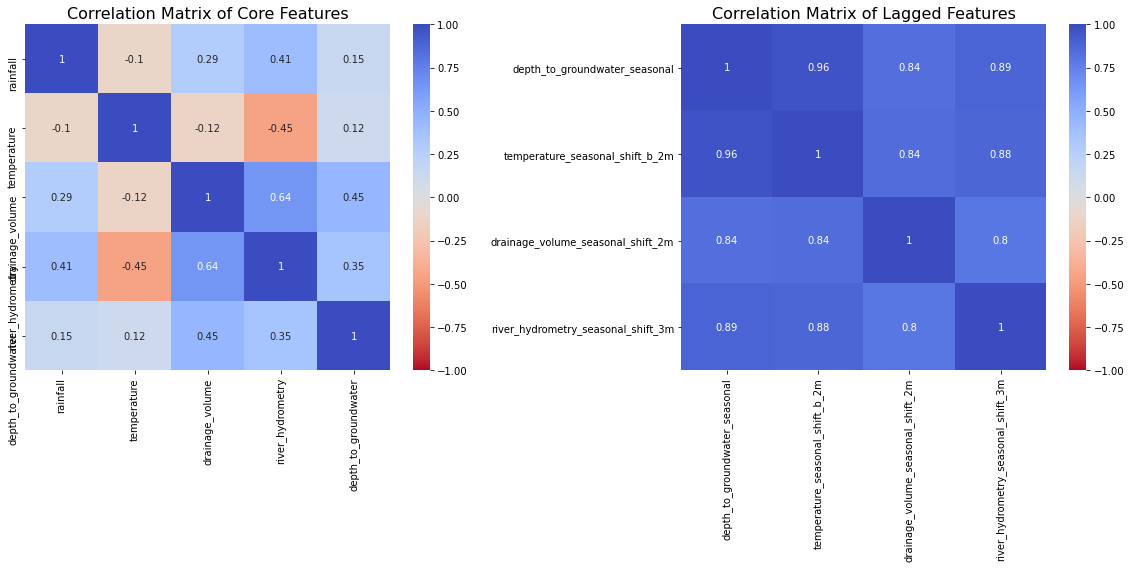

In [29]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

corrmat = df[core_columns].corr()

sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=ax[0])
ax[0].set_title('Correlation Matrix of Core Features', fontsize=16)

shifted_cols = [
    'depth_to_groundwater_seasonal',         
    'temperature_seasonal_shift_b_2m',
    'drainage_volume_seasonal_shift_2m', 
    'river_hydrometry_seasonal_shift_3m'
]
corrmat = df[shifted_cols].corr()

sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=ax[1])
ax[1].set_title('Correlation Matrix of Lagged Features', fontsize=16)


plt.tight_layout()
plt.show()

Como podemos ver, las características están muy correlacionadas en el caso de las características desplazadas (retardadas) en comparación con las originales.

<a id='4.1'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:120%; text-align:center">4.1 Análisis de autocorrelación</p>

Gráficos ACF y PACF: Después de estacionalizar una serie temporal diferenciándola, el siguiente paso para ajustar un modelo ARIMA es determinar si se necesitan términos AR o MA para corregir cualquier autocorrelación que permanezca en la serie diferenciada. Por supuesto, con un programa como Statgraphics, puede probar diferentes combinaciones de términos y ver cuál funciona mejor. Pero hay una forma más sistemática de hacerlo. Observando los gráficos de **función de autocorrelación (ACF)** y **autocorrelación parcial (PACF)** de las series diferenciadas, puede identificar provisionalmente el número de términos AR y/o MA necesarios.f

* **Función de autocorrelación (ACF)**: P = Periodos de retardo para, por ejemplo: (si P= 3 entonces utilizaremos los tres periodos anteriores de nuestra serie temporal en la parte autorregresiva del cálculo) P ayuda a ajustar la línea que se está ajustando para pronosticar la serie. P se corresponde con el parámetro MA.
* **Partial Autocorrelation Function (PACF)**: D = En un modelo ARIMA transformamos una serie temporal en estacionaria (serie sin tendencia ni estacionalidad) utilizando la diferenciación. D se refiere al número de transformaciones de diferenciación que necesita la serie temporal para hacerse estacionaria. D se corresponde con el parámetro AR.

Los gráficos de autocorrelación ayudan a detectar la estacionalidad.

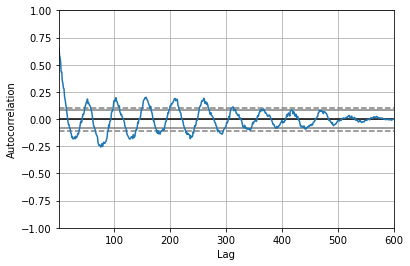

In [30]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(df['depth_to_groundwater_diff_1'])
plt.show()

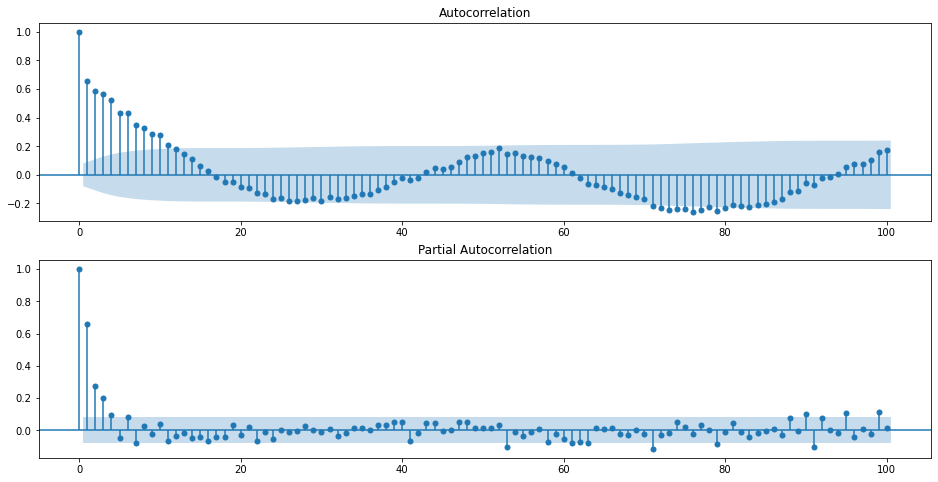

In [31]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

plot_acf(df['depth_to_groundwater_diff_1'], lags=100, ax=ax[0])
plot_pacf(df['depth_to_groundwater_diff_1'], lags=100, ax=ax[1])

plt.show()

<a id='5'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center">5. Modelado 🧩</p>

Las series temporales pueden ser univariantes o multivariantes:

- **Series temporales univariantes** sólo tienen una variable dependiente del tiempo.
- **Series temporales multivariantes** tienen múltiples variables dependientes del tiempo.

Pero, en primer lugar, vamos a ver cómo funciona la técnica de validación cruzada en el Análisis de Series Temporales. 

In [32]:
from sklearn.model_selection import TimeSeriesSplit

N_SPLITS = 3

X = df['date']
y = df['depth_to_groundwater']

folds = TimeSeriesSplit(n_splits=N_SPLITS)

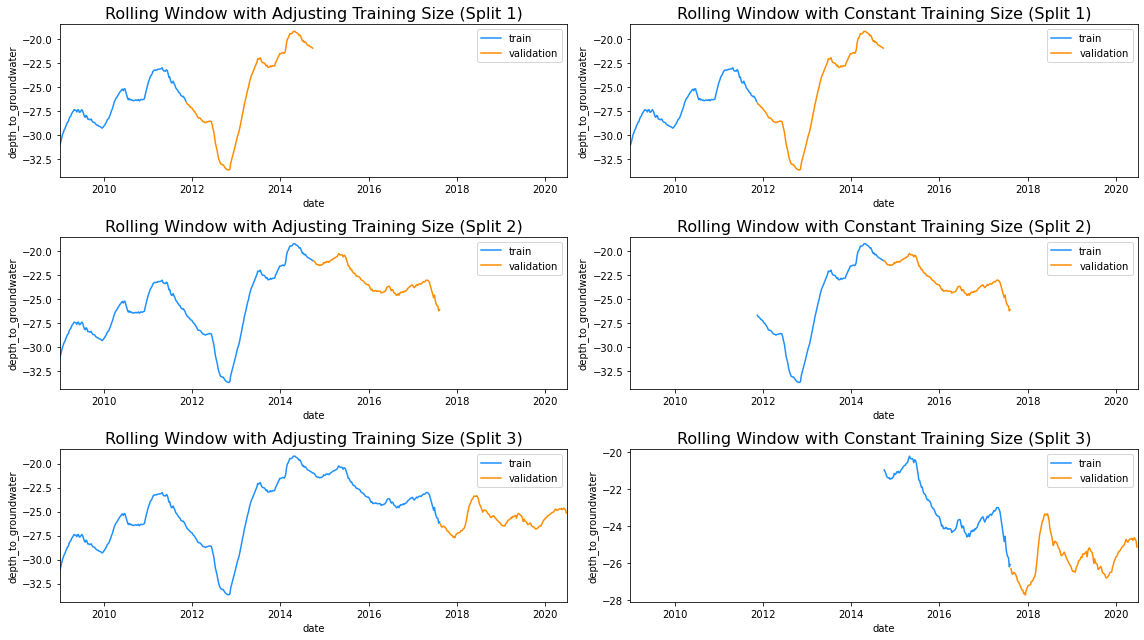

In [33]:
f, ax = plt.subplots(nrows=N_SPLITS, ncols=2, figsize=(16, 9))

for i, (train_index, valid_index) in enumerate(folds.split(X)):
    X_train, X_valid = X[train_index], X[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]

    sns.lineplot(
        x=X_train, 
        y=y_train, 
        ax=ax[i,0], 
        color='dodgerblue', 
        label='train'
    )
    sns.lineplot(
        x=X_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))], 
        y=y_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))], 
        ax=ax[i,1], 
        color='dodgerblue', 
        label='train'
    )

    for j in range(2):
        sns.lineplot(x= X_valid, y= y_valid, ax=ax[i, j], color='darkorange', label='validation')
    ax[i, 0].set_title(f"Rolling Window with Adjusting Training Size (Split {i+1})", fontsize=16)
    ax[i, 1].set_title(f"Rolling Window with Constant Training Size (Split {i+1})", fontsize=16)

for i in range(N_SPLITS):
    ax[i, 0].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
    ax[i, 1].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
    
plt.tight_layout()
plt.show()

La idea detrás de este gráfico es entender qué conjunto de entrenamiento y prueba estamos utilizando para ajustar el modelo en cada iteración. 

<a id='5.1'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:120%; text-align:center">5.1 Modelos de series temporales univariantes</p>

En primer lugar, vamos a analizar la previsión de series temporales univariantes.

**Series temporales univariantes**: Sólo una variable varía en el tiempo. Por ejemplo, los datos recogidos de un sensor que mide la temperatura de una habitación cada segundo. Por lo tanto, cada segundo, sólo tendrá un valor unidimensional, que es la temperatura.

In [34]:
train_size = int(0.85 * len(df))
test_size = len(df) - train_size

univariate_df = df[['date', 'depth_to_groundwater']].copy()
univariate_df.columns = ['ds', 'y']

train = univariate_df.iloc[:train_size, :]

x_train, y_train = pd.DataFrame(univariate_df.iloc[:train_size, 0]), pd.DataFrame(univariate_df.iloc[:train_size, 1])
x_valid, y_valid = pd.DataFrame(univariate_df.iloc[train_size:, 0]), pd.DataFrame(univariate_df.iloc[train_size:, 1])

print(len(train), len(x_valid))

510 90


<a id='5.1.1'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:100%; text-align:center">5.1.1 Profeta</p>

El primer modelo (que también puede tratar problemas multivariantes) que vamos a probar es Facebook Prophet.

Prophet, o "Facebook Prophet", es una biblioteca de código abierto para la previsión de series temporales univariantes (una variable) desarrollada por Facebook.

Prophet implementa lo que ellos denominan un modelo aditivo de previsión de series temporales, y la implementación admite tendencias, estacionalidad y días festivos.

In [35]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

from fbprophet import Prophet


# Train the model
model = Prophet()
model.fit(train)

# x_valid = model.make_future_dataframe(periods=test_size, freq='w')

# Predict on valid set
y_pred = model.predict(x_valid)

# Calcuate metrics
score_mae = mean_absolute_error(y_valid, y_pred.tail(test_size)['yhat'])
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred.tail(test_size)['yhat']))

print(Fore.GREEN + 'RMSE: {}'.format(score_rmse))

RMSE: 1.199099789648606


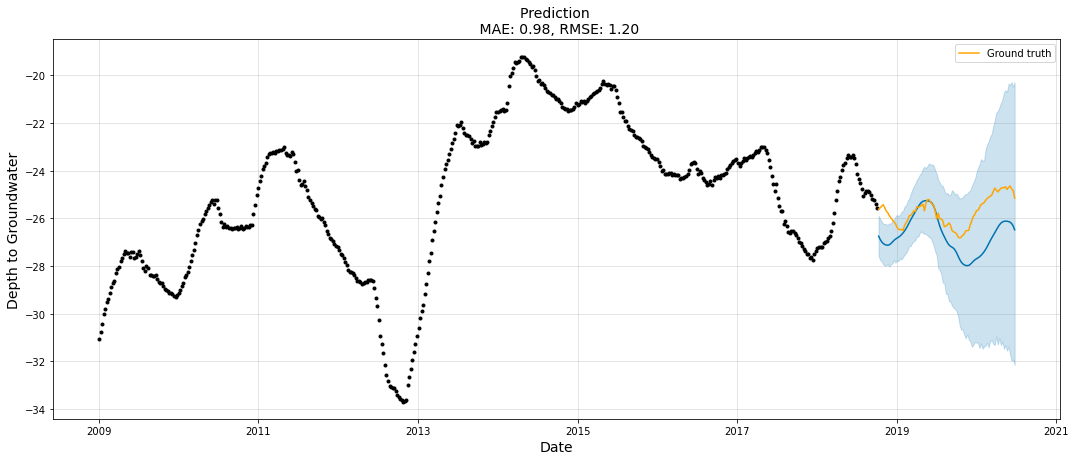

In [36]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

model.plot(y_pred, ax=ax)
sns.lineplot(x=x_valid['ds'], y=y_valid['y'], ax=ax, color='orange', label='Ground truth') #navajowhite

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Depth to Groundwater', fontsize=14)

plt.show()

<a id='5.1.2'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:100%; text-align:center">5.1.2 ARIMA</p>

El segundo modelo que quiero probar es ARIMA.

El modelo de media móvil integrada autorregresiva (ARIMA) describe las **autocorrelaciones** de los datos. El modelo supone que la serie temporal es **estacionaria**. Consta de tres partes principales:
* <font color='purple'>Filtro autorregresivo (AR) (a largo plazo)</font>: 
    
    $\color{purple}{y_t = c + \alpha_1 y_{t-1} + \dots \alpha_{\color{purple}p}y_{t-\color{purple}p} + \epsilon_t = c + \sum_{i=1}^p{\alpha_i}y_{t-i} + \epsilon_t}$  -> p
* <font color='orange'> Filtro de integración (tendencia estocástica)</font>
    
    -> d
* <font color='blue'>Filtro de media móvil (MA) (corto plazo)</font>:

    $\color{blue}{y_t = c + \epsilon_t + \beta_1 \epsilon_{t-1} + \dots + \beta_{q} \epsilon_{t-q} = c + \epsilon_t + \sum_{i=1}^q{\beta_i}\epsilon_{t-i}} $  -> q 


**ARIMA**: $y_t = c + \color{purple}{\alpha_1 y_{t-1} + \dots + \alpha_{\color{purple}p}y_{t-\color{purple}p}} + \color{blue}{\epsilon_t + \beta_1 \epsilon_{t-1} + \dots + \beta_{q} \epsilon_{t-q}}$


ARIMA(
<font color='purple'>p</font>,
<font color='orange'>d</font>,
<font color='blue'>q</font>)

* <font color='purple'>p</font>: Orden de desfase (referencia PACF en [Análisis de autocorrelación](#4.1-Autocorrelation-Analysis))
* <font color='orange'>d</font>: Grado de diferenciación. (referencia Diferenciación en [Estacionariedad](#2.3-Stationarity))
* <font color='blue'>q</font>: Orden de la media móvil (consulte ACF en [Análisis de autocorrelación](#4.1-Autocorrelation-Analysis))

### Pasos para analizar ARIMA

* **Paso 1 - Comprobar la estacionariedad**: Si una serie temporal tiene un componente de tendencia o estacionalidad, debe hacerse estacionaria antes de poder utilizar ARIMA para pronosticar.
* **Paso 2 - Diferencia**: Si la serie temporal no es estacionaria, es necesario estacionarla mediante diferencias. Tome la primera diferencia y compruebe la estacionariedad. Tome tantas diferencias como sea necesario. Asegúrese de comprobar también la diferenciación estacional.
* **Paso 3 - Filtrar una muestra de validación**: Esto se utilizará para validar la precisión de nuestro modelo. Utilice la división de validación de prueba de entrenamiento para lograr esto.
* **Paso 4 - Seleccione los términos AR y MA**: Utilice el ACF y el PACF para decidir si incluir un término o términos AR, MA o ambos.
* **Paso 5 - Construir el modelo**: Construya el modelo y establezca el número de periodos a pronosticar en N (depende de sus necesidades).
* **Paso 6 - Validación del modelo**: Compare los valores previstos con los reales de la muestra de validación.

In [37]:
from statsmodels.tsa.arima_model import ARIMA

# Fit model
model = ARIMA(y_train, order=(1,1,1))
model_fit = model.fit()

# Prediction with ARIMA
y_pred, se, conf = model_fit.forecast(90)

# Calcuate metrics
score_mae = mean_absolute_error(y_valid, y_pred)
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred))

print(Fore.GREEN + 'RMSE: {}'.format(score_rmse))

RMSE: 0.8858252746421527


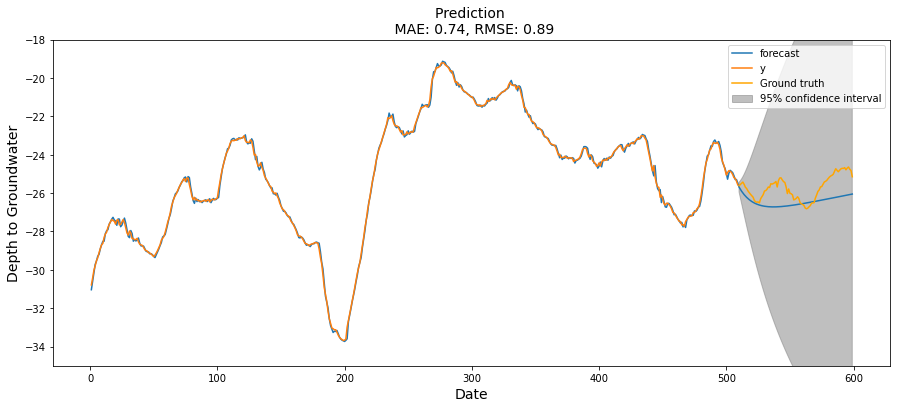

In [38]:
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

model_fit.plot_predict(1, 599, ax=ax)
sns.lineplot(x=x_valid.index, y=y_valid['y'], ax=ax, color='orange', label='Ground truth') #navajowhite

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Depth to Groundwater', fontsize=14)

ax.set_ylim(-35, -18)
plt.show()

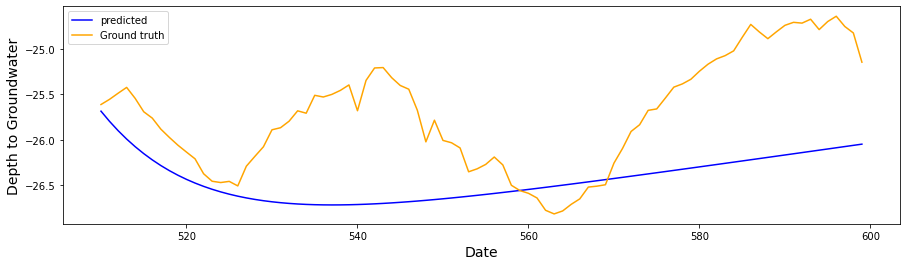

In [39]:
f, ax = plt.subplots(1)
f.set_figheight(4)
f.set_figwidth(15)

sns.lineplot(x=x_valid.index, y=y_pred, ax=ax, color='blue', label='predicted') #navajowhite
sns.lineplot(x=x_valid.index, y=y_valid['y'], ax=ax, color='orange', label='Ground truth') #navajowhite

ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Depth to Groundwater', fontsize=14)

plt.show()

<a id='5.1.3'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:100%; text-align:center">5.1.3 Auto-ARIMA</p>

In [40]:
!pip install pmdarima

     |████████████████████████████████| 1.5 MB 866 kB/s 
     |████████████████████████████████| 2.1 MB 4.4 MB/s 
  Attempting uninstall: Cython
    Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [41]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

model = pm.auto_arima(y_train, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-631.136, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-242.692, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-574.047, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-427.347, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-243.054, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-629.209, Time=0.48 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-629.237, Time=0.77 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-492.779, Time=0.27 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-611.065, Time=0.19 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-628.351, Time=1.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-632.995, Time=0.25 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-428.258, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-575.735, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-631.069, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0]          

Como vimos en los Pasos anteriores, AutoARIMA (auto_arima) valida que (1,1,1) es la mejor configuración para (p,d,q).

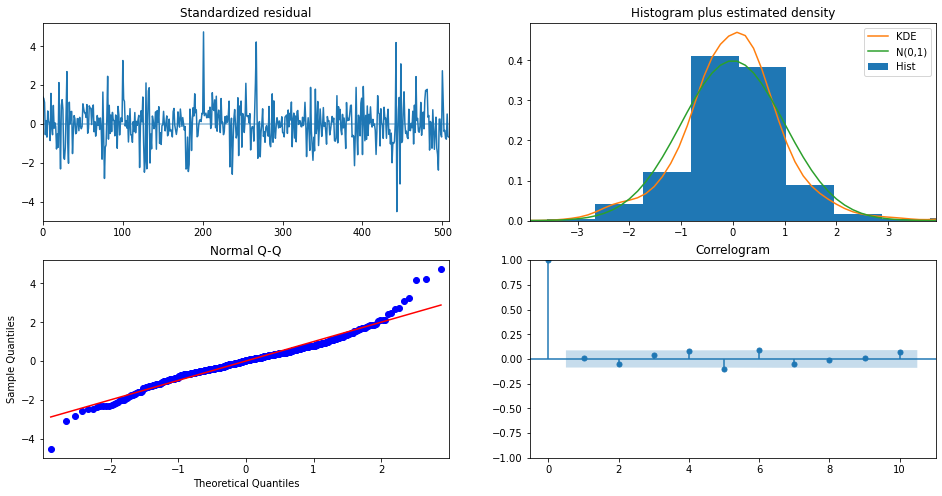

In [42]:
model.plot_diagnostics(figsize=(16,8))
plt.show()

¿Cómo interpretar el diagnóstico del diagrama?

- **Arriba a la izquierda**: Los errores residuales parecen fluctuar alrededor de una media de cero y tienen una varianza uniforme entre (-4, 4).

- **Arriba a la derecha**: El diagrama de densidad sugiere una distribución normal con una media de cero.

- **Abajo a la izquierda**: La mayor parte de los puntos azules están por encima de la línea roja, por lo que parece que la distribución es poco asimétrica (para mí no es asimétrica).

- **Abajo a la derecha**: El correlograma, también conocido como gráfico ACF, muestra que los errores residuales no están autocorrelacionados.

<a id='5.1.4'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:100%; text-align:center">5.1.4 LSTM</p>

Vamos a utilizar una red neuronal recurrente LSTM multicapa para predecir el último valor de una secuencia de valores.

Antes de construir el modelo LSTM es necesario realizar el siguiente preprocesamiento de datos e ingeniería de características.
- Crear el conjunto de datos, asegurarse de que todos los datos son flotantes.
- Normalizar las características.
- Dividir en conjuntos de entrenamiento y prueba.
- Convertir una matriz de valores en una matriz de datos.
- Reformar X=t e Y=t+1.
- Reformar la entrada para que sea 3D (num_samples, num_timesteps, num_features).

In [43]:
from sklearn.preprocessing import MinMaxScaler

data = univariate_df.filter(['y'])
# Convert the dataframe to a numpy array
dataset = data.values

scaler = MinMaxScaler(feature_range=(-1, 0))
scaled_data = scaler.fit_transform(dataset)

scaled_data[:10]

array([[-0.81796644],
       [-0.79970385],
       [-0.7745311 ],
       [-0.74679171],
       [-0.73099704],
       [-0.71253702],
       [-0.7023692 ],
       [-0.68410661],
       [-0.66890424],
       [-0.65528134]])

In [44]:
# Defines the rolling window
look_back = 52
# Split into train and test sets
train, test = scaled_data[:train_size-look_back,:], scaled_data[train_size-look_back:,:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(look_back, len(dataset)):
        a = dataset[i-look_back:i, 0]
        X.append(a)
        Y.append(dataset[i, 0])
    return np.array(X), np.array(Y)

x_train, y_train = create_dataset(train, look_back)
x_test, y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

print(len(x_train), len(x_test))

406 90


In [45]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=5, validation_data=(x_test, y_test))

model.summary()

Epoch 1/5
406/406 [==============================] - 4s 5ms/step - loss: 0.0178 - val_loss: 0.0091
Epoch 2/5
406/406 [==============================] - 1s 3ms/step - loss: 0.0039 - val_loss: 3.7996e-04
Epoch 3/5
406/406 [==============================] - 1s 3ms/step - loss: 0.0016 - val_loss: 8.1765e-04
Epoch 4/5
406/406 [==============================] - 1s 3ms/step - loss: 0.0011 - val_loss: 3.7027e-04
Epoch 5/5
406/406 [==============================] - 1s 3ms/step - loss: 0.0014 - val_loss: 0.0031
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 128)            92672     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 25)                1625      
___________

In [46]:
# Let's predict with the model
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

# Invert predictions
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])

test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

# Get the root mean squared error (RMSE) and MAE
score_rmse = np.sqrt(mean_squared_error(y_test[0], test_predict[:,0]))
score_mae = mean_absolute_error(y_test[0], test_predict[:,0])
print(Fore.GREEN + 'RMSE: {}'.format(score_rmse))

RMSE: 0.8032011475525961


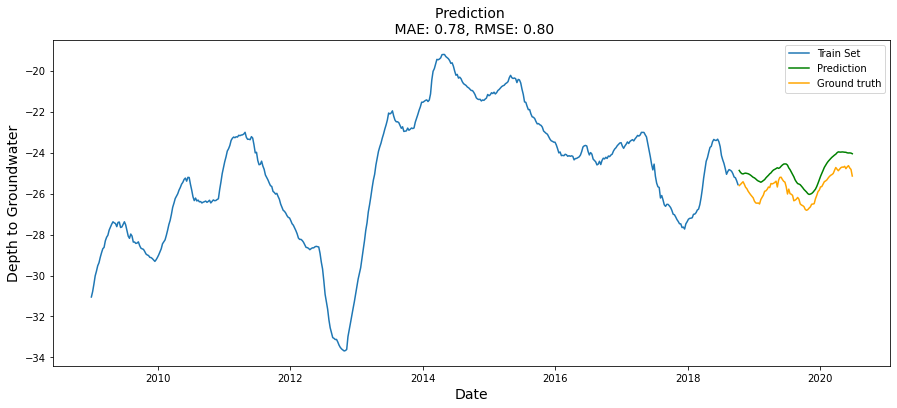

In [47]:
x_train_ticks = univariate_df.head(train_size)['ds']
y_train = univariate_df.head(train_size)['y']
x_test_ticks = univariate_df.tail(test_size)['ds']

# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

sns.lineplot(x=x_train_ticks, y=y_train, ax=ax, label='Train Set') #navajowhite
sns.lineplot(x=x_test_ticks, y=test_predict[:,0], ax=ax, color='green', label='Prediction') #navajowhite
sns.lineplot(x=x_test_ticks, y=y_test[0], ax=ax, color='orange', label='Ground truth') #navajowhite

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Depth to Groundwater', fontsize=14)

plt.show()

<a id='5.2'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:120%; text-align:center">5.2 Modelos de series temporales multivariantes</p>

Por último, vamos a analizar las previsiones multivariantes de series temporales.

**Series temporales multivariantes:** Varias variables varían con el tiempo. Por ejemplo, un acelerómetro triaxial. Hay tres aceleraciones, una para cada eje (x,y,z) y varían simultáneamente con el tiempo.

In [48]:
feature_columns = [
    'rainfall',
    'temperature',
    'drainage_volume',
    'river_hydrometry',
]
target_column = ['depth_to_groundwater']

train_size = int(0.85 * len(df))

multivariate_df = df[['date'] + target_column + feature_columns].copy()
multivariate_df.columns = ['ds', 'y'] + feature_columns

train = multivariate_df.iloc[:train_size, :]
x_train, y_train = pd.DataFrame(multivariate_df.iloc[:train_size, [0,2,3,4,5]]), pd.DataFrame(multivariate_df.iloc[:train_size, 1])
x_valid, y_valid = pd.DataFrame(multivariate_df.iloc[train_size:, [0,2,3,4,5]]), pd.DataFrame(multivariate_df.iloc[train_size:, 1])

train.head()

,ds,y,rainfall,temperature,drainage_volume,river_hydrometry
0,2009-01-01,-31.048571,0.000000,1.657143,-28164.918857,2.371429
1,2009-01-08,-30.784286,0.285714,4.571429,-29755.789714,2.314286
2,2009-01-15,-30.420000,0.028571,7.528571,-25463.190857,2.300000
3,2009-01-22,-30.018571,0.585714,6.214286,-23854.422857,2.500000
4,2009-01-29,-29.790000,1.414286,5.771429,-25210.532571,2.500000


<a id='5.2.1'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:100%; text-align:center">5.2.1 Multivariate Prophet</p>

In [49]:
from fbprophet import Prophet


# Train the model
model = Prophet()
model.add_regressor('rainfall')
model.add_regressor('temperature')
model.add_regressor('drainage_volume')
model.add_regressor('river_hydrometry')

# Fit the model with train set
model.fit(train)

# Predict on valid set
y_pred = model.predict(x_valid)

# Calcuate metrics
score_mae = mean_absolute_error(y_valid, y_pred['yhat'])
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred['yhat']))

print(Fore.GREEN + 'RMSE: {}'.format(score_rmse))

RMSE: 0.9940444133552163


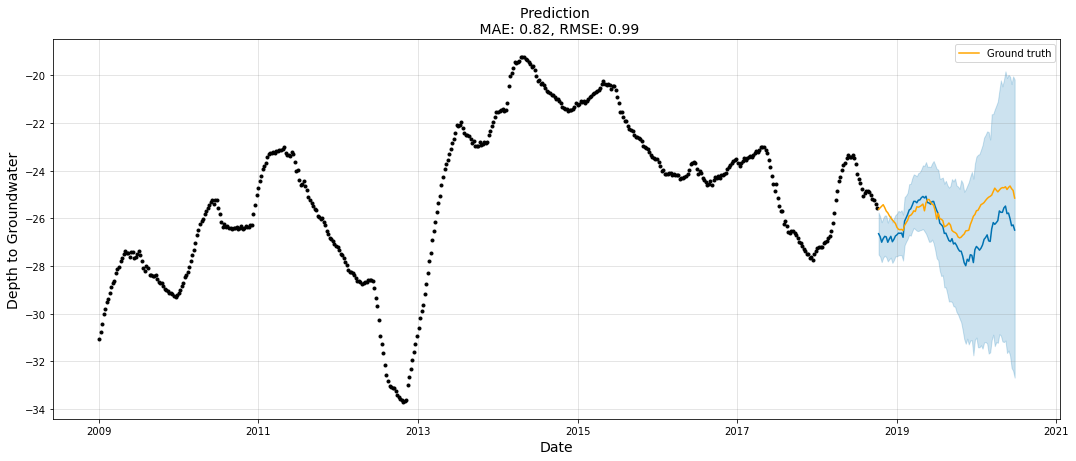

In [50]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

model.plot(y_pred, ax=ax)
sns.lineplot(x=x_valid['ds'], y=y_valid['y'], ax=ax, color='orange', label='Ground truth') #navajowhite

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Depth to Groundwater', fontsize=14)

plt.show()

<a id='6'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center">6. Conclusions 💎</p>

Los mejores resultados se obtienen con LSTM univariante (con ventana móvil de 1 año) y Prophet multivariante.

<a id='7'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center">7. References 📝</p>

Aquí voy a referenciar algunos enlaces útiles que he utilizado para construir este cuaderno
- Referencia especial para la información útil y los gráficos - https://www.kaggle.com/iamleonie/intro-to-time-series-forecasting
- ARIMA - https://towardsdatascience.com/time-series-forecasting-arima-models-7f221e9eee06
- Auto-ARIMA - https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/
- Keras LSTM - https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
- Profeta - https://towardsdatascience.com/time-series-prediction-using-prophet-in-python-35d65f626236
- Referencia especial - https://www.kaggle.com/iamleonie/intro-to-time-series-forecasting/notebook#Models
- Características cíclicas - https://towardsdatascience.com/cyclical-features-encoding-its-about-time-ce23581845ca
- ADF - https://medium.com/@cmukesh8688/why-is-augmented-dickey-fuller-test-adf-test-so-important-in-time-series-analysis-6fc97c6be2f0
- ACF/PACF - https://towardsdatascience.com/significance-of-acf-and-pacf-plots-in-time-series-analysis-2fa11a5d10a8
- LSTM - https://towardsdatascience.com/time-series-analysis-visualization-forecasting-with-lstm-77a905180eba